# Проект "Рейтинг ресторанов"
Суть проекта - создать модель, которая должна будет предсказывать рейтинг ресторана по данным сайта TripAdvisor на основе имеющихся в датасете данных.
## Описание модели
Restaurant_id — идентификационный номер ресторана / сети ресторанов; <br />
City — город, в котором находится ресторан;<br />
Cuisine Style — кухня или кухни, к которым можно отнести блюда, предлагаемые в ресторане;<br />
Ranking — место, которое занимает данный ресторан среди всех ресторанов своего города;<br />
Rating — рейтинг ресторана по данным TripAdvisor (именно это значение должна будет предсказывать модель);<br />
Price Range — диапазон цен в ресторане;<br />
Number of Reviews — количество отзывов о ресторане;<br />
Reviews — данные о двух отзывах, которые отображаются на сайте ресторана;<br />
URL_TA — URL страницы ресторана на TripAdvosor;<br />
ID_TA — идентификатор ресторана в базе данных TripAdvisor.<br />

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import collections
%matplotlib inline

RANDOM_SEED = 42
!pip freeze > requirements.txt

DATA_DIR = './kaggle/input/sf-dst-restaurant-rating'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'/kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [2]:
# Для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

df = df_test.append(df_train, sort=False).reset_index(drop=True)
df['id'] = range(0, len(df))

display('Исходные названия признаков:', df.columns)
df.columns = ['chain_id', 'city', 'styles', 'ranking', 'price_range', 'reviews_count', 'reviews', 'url_ta', 'id_ta', 'sample', 'rating', 'id']
display('Обновленные названия признаков:', df.columns)

'Исходные названия признаков:'

Index(['Restaurant_id', 'City', 'Cuisine Style', 'Ranking', 'Price Range',
       'Number of Reviews', 'Reviews', 'URL_TA', 'ID_TA', 'sample', 'Rating',
       'id'],
      dtype='object')

'Обновленные названия признаков:'

Index(['chain_id', 'city', 'styles', 'ranking', 'price_range', 'reviews_count',
       'reviews', 'url_ta', 'id_ta', 'sample', 'rating', 'id'],
      dtype='object')

# Обработка данных

In [3]:
display(df.head())
display(df.info())

,chain_id,city,styles,ranking,price_range,reviews_count,reviews,url_ta,id_ta,sample,rating,id
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,0
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,1
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,2
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,3
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,4


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   chain_id       50000 non-null  object 
 1   city           50000 non-null  object 
 2   styles         38410 non-null  object 
 3   ranking        50000 non-null  float64
 4   price_range    32639 non-null  object 
 5   reviews_count  46800 non-null  float64
 6   reviews        49998 non-null  object 
 7   url_ta         50000 non-null  object 
 8   id_ta          50000 non-null  object 
 9   sample         50000 non-null  int64  
 10  rating         50000 non-null  float64
 11  id             50000 non-null  int64  
dtypes: float64(3), int64(2), object(7)
memory usage: 4.6+ MB


None

**Данные без пропусков:** id city ranking url_ta id_ta

**С пропусками:** styles price_range reviews_count reviews

**Числовые:** ranking reviews_count 

# Поле ID

In [4]:
'''
    Поле id в исходном датафрейме не уникально. Здесь речь идет о ресторанных сетях. 
    Добавим уникальное id, чтобы было удобно работать с данными.

    Добавим признаки:
    rest_chain_count - которое будет равно кол-ву ресторанов в сети.
    is_rest_chain - которое будет равно 1, если это сеть ресторанов и 0 иначе
'''

def makeRestChainDataFrame(sourceDf):
    c = collections.Counter()
    def calc_chains(id):
        c[id] += 1        
    sourceDf['chain_id'].apply(lambda chain_id: calc_chains(chain_id))
    res = pd.DataFrame(sourceDf['id'])
    res['is_rest_chain'] = sourceDf['chain_id'].apply(lambda chain_id: int(c[chain_id] != 1))
    res['rest_chain_count'] = sourceDf['chain_id'].apply(lambda chain_id: c[chain_id])        
    
    return res;    

In [5]:
restChainDataFrame = makeRestChainDataFrame(df)
display(restChainDataFrame.head())
display(restChainDataFrame.info())

,id,is_rest_chain,rest_chain_count
0,0,1,16
1,1,1,10
2,2,1,15
3,3,1,9
4,4,1,14


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   id                50000 non-null  int64
 1   is_rest_chain     50000 non-null  int64
 2   rest_chain_count  50000 non-null  int64
dtypes: int64(3)
memory usage: 1.1 MB


None

# Поле "Город" (City)

In [6]:
from sklearn import preprocessing

''' В нашем датасете есть города, значит мы можем установить для каждой записи страну 
    и новый признак - столица или нет. Вероятно, это может дать эффект, так как 
    в разных странах разный менталитет и достаток у людей. В столицах обычно также 
    достаток, а значит и нравы людей, отличаются от провинции.
'''
city_country = {
        'London': 'UK',
        'Paris': 'France',
        'Madrid': 'Spain',
        'Barcelona': 'Spain',
        'Berlin': 'Germany',
        'Milan': 'Italy',
        'Rome': 'Italy',
        'Prague': 'Czech',
        'Lisbon': 'Portugalia',
        'Vienna': 'Austria',
        'Amsterdam': 'Nederlands',
        'Brussels': 'Belgium',
        'Hamburg': 'Germany',
        'Munich': 'Germany',
        'Lyon': 'France',
        'Stockholm': 'Sweden',
        'Budapest': 'Hungary',
        'Warsaw': 'Poland',
        'Dublin': 'Ireland',
        'Copenhagen': 'Denmark',
        'Athens': 'Greece',
        'Edinburgh': 'Schotland',
        'Zurich': 'Switzerland',
        'Oporto': 'Portugalia',
        'Geneva': 'Switzerland',
        'Krakow': 'Poland',
        'Oslo': 'Norway',
        'Helsinki': 'Finland',
        'Bratislava': 'Slovakia',
        'Luxembourg': 'Luxembourg',
        'Ljubljana': 'Slovenija'
    }

countryCapitals = [
        'London', 'Paris', 'Madrid', 'Berlin', 'Rome', 'Prague', 'Lisbon',
        'Vienna', 'Amsterdam', 'Brussels', 'Stockholm', 'Budapest', 'Warsaw',
        'Dublin', 'Copenhagen', 'Athens', 'Oslo', 'Helsinki', 'Bratislava',
        'Luxembourg', 'Ljubljana', 'Edinburgh'
    ]

'''
    Зная город можем использовать информацию о его численности.
'''
population = {
        'Paris': 2190327,
        'Stockholm': 961609,
        'London': 8908081,
        'Berlin': 3644826,
        'Munich': 1456039,
        'Oporto': 237591,
        'Milan': 1378689,
        'Bratislava': 432864,
        'Vienna': 1821582,
        'Rome': 4355725,
        'Barcelona': 1620343,
        'Madrid': 3223334,
        'Dublin': 1173179,
        'Brussels': 179277,
        'Zurich': 428737,
        'Warsaw': 1758143,
        'Budapest': 1752286,
        'Copenhagen': 615993,
        'Amsterdam': 857713,
        'Lyon': 506615,
        'Hamburg': 1841179,
        'Lisbon': 505526,
        'Prague': 1301132,
        'Oslo': 673469,
        'Helsinki': 643272,
        'Edinburgh': 488100,
        'Geneva': 200548,
        'Ljubljana': 284355,
        'Athens': 664046,
        'Luxembourg': 115227,
        'Krakow': 769498
    }

In [7]:
def makeCountryDataFrame(sourceDf):
    countries = pd.DataFrame(sourceDf[['id', 'city']])
    countries['country'] = countries['city'].apply(lambda c: city_country[c])            
    countries = countries.drop(['city'], axis=1)
    countries = pd.get_dummies(countries, ['country'])    
    return countries

In [8]:
countryDataFrame = makeCountryDataFrame(df)
display(countryDataFrame.head())
display(countryDataFrame.info())

,id,country_Austria,country_Belgium,country_Czech,country_Denmark,country_Finland,country_France,country_Germany,country_Greece,country_Hungary,...,country_Norway,country_Poland,country_Portugalia,country_Schotland,country_Slovakia,country_Slovenija,country_Spain,country_Sweden,country_Switzerland,country_UK
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   id                   50000 non-null  int64
 1   country_Austria      50000 non-null  uint8
 2   country_Belgium      50000 non-null  uint8
 3   country_Czech        50000 non-null  uint8
 4   country_Denmark      50000 non-null  uint8
 5   country_Finland      50000 non-null  uint8
 6   country_France       50000 non-null  uint8
 7   country_Germany      50000 non-null  uint8
 8   country_Greece       50000 non-null  uint8
 9   country_Hungary      50000 non-null  uint8
 10  country_Ireland      50000 non-null  uint8
 11  country_Italy        50000 non-null  uint8
 12  country_Luxembourg   50000 non-null  uint8
 13  country_Nederlands   50000 non-null  uint8
 14  country_Norway       50000 non-null  uint8
 15  country_Poland       50000 non-null  uint8
 16  country_Portugalia   5

None

In [9]:
def makeCapitalDataFrame(sourceDf):
    capitals = pd.DataFrame(sourceDf[['id', 'city']])            
    capitals['is_capital'] = capitals['city'].apply(lambda c: 1 if c in countryCapitals else 0)            
    capitals = capitals.drop(['city'], axis=1)
    return capitals

In [10]:
capitalDataframe = makeCapitalDataFrame(df)
display(capitalDataframe.head())
display(capitalDataframe.info())

,id,is_capital
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   id          50000 non-null  int64
 1   is_capital  50000 non-null  int64
dtypes: int64(2)
memory usage: 781.4 KB


None

In [11]:
# для городов мы указываем их население
def makeCitiesDataFrame(sourceDf):        
    cities = pd.get_dummies(df[['id', 'city']], columns=['city'])        
    cities = cities.merge(sourceDf[['id', 'city']], on='id', how='left')    
    rest_city_count = cities['city'].value_counts(ascending=False)    
    cities['rest_city_count'] = cities['city'].apply(lambda s: rest_city_count[s])                            
    cities['city_population'] = cities['city'].apply(lambda c: population[c])            
    cities = cities.drop(['city'], axis=1)
    return cities

In [12]:
citiesDataFrame = makeCitiesDataFrame(df)
display(citiesDataFrame.head())
display(citiesDataFrame.info())

,id,city_Amsterdam,city_Athens,city_Barcelona,city_Berlin,city_Bratislava,city_Brussels,city_Budapest,city_Copenhagen,city_Dublin,...,city_Oslo,city_Paris,city_Prague,city_Rome,city_Stockholm,city_Vienna,city_Warsaw,city_Zurich,rest_city_count,city_population
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,6108,2190327
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,475,643272
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,745,488100
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,7193,8908081
4,4,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,380,432864


<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 34 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   id               50000 non-null  int64
 1   city_Amsterdam   50000 non-null  uint8
 2   city_Athens      50000 non-null  uint8
 3   city_Barcelona   50000 non-null  uint8
 4   city_Berlin      50000 non-null  uint8
 5   city_Bratislava  50000 non-null  uint8
 6   city_Brussels    50000 non-null  uint8
 7   city_Budapest    50000 non-null  uint8
 8   city_Copenhagen  50000 non-null  uint8
 9   city_Dublin      50000 non-null  uint8
 10  city_Edinburgh   50000 non-null  uint8
 11  city_Geneva      50000 non-null  uint8
 12  city_Hamburg     50000 non-null  uint8
 13  city_Helsinki    50000 non-null  uint8
 14  city_Krakow      50000 non-null  uint8
 15  city_Lisbon      50000 non-null  uint8
 16  city_Ljubljana   50000 non-null  uint8
 17  city_London      50000 non-null  uint8
 18  city_L

None

# Поле "Кухни" (styles)

In [13]:
display(df['styles'].describe())

count           38410
unique          10731
top       ['Italian']
freq             1332
Name: styles, dtype: object

In [14]:
'''
    Кухни имею пустые значения, их заменим на "mixed", сохранив при этом признак пустоты.
    Также выпишем все самые популярные кухни и сделаем dummy-переменные.
'''

def makeStylesDataFrame(sourceDf, topStylesCount):        
    default_style = '[\'mixed\']'
    styles = pd.DataFrame(sourceDf[['id', 'styles', 'city']])
    styles['styles_isna'] = pd.isna(styles['styles']).astype('uint8')
    styles['styles'] = styles['styles'].fillna(default_style)
    styles['styles'] = styles['styles'].replace('[[],[]]', default_style)
    
    # найдем сколько раз встречается каждая кухня
    counter = collections.Counter()    
    def calc_styles(str_styles):
        arr = str_styles.replace('[', '').replace(']', '').replace('\'', '').replace(' ', '').split(',')    
        for s in arr:
            counter[s] += 1
            
    styles['styles'].apply(lambda s: calc_styles(s))    
    most_common_styles = counter.most_common(topStylesCount)
                
    styles['styles_count'] = styles['styles'].apply(lambda s: len(s.split(',')));
    for style in most_common_styles:
        styles['style_' + style[0]] = styles['styles'].apply(lambda str_styles: int(style[0] in str_styles))
        
    styles['styles_count_norm'] = styles['styles_count'] / styles['city'].map(styles.groupby(['city'])['styles_count'].max())
    
    styles = styles.drop(['city', 'styles'], axis=1)
    return styles

In [15]:
stylesDataFrame = makeStylesDataFrame(df, 50)
display(stylesDataFrame.head())
display(stylesDataFrame.info())

,id,styles_isna,styles_count,style_VegetarianFriendly,style_European,style_mixed,style_Mediterranean,style_Italian,style_VeganOptions,style_GlutenFreeOptions,...,style_Gastropub,style_Turkish,style_Mexican,style_SouthAmerican,style_Delicatessen,style_Austrian,style_Polish,style_Scandinavian,style_Hungarian,styles_count_norm
0,0,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.222222
1,1,0,5,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0.625000
2,2,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.100000
3,3,0,5,0,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0.500000
4,4,0,6,0,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0.750000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 54 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        50000 non-null  int64  
 1   styles_isna               50000 non-null  uint8  
 2   styles_count              50000 non-null  int64  
 3   style_VegetarianFriendly  50000 non-null  int64  
 4   style_European            50000 non-null  int64  
 5   style_mixed               50000 non-null  int64  
 6   style_Mediterranean       50000 non-null  int64  
 7   style_Italian             50000 non-null  int64  
 8   style_VeganOptions        50000 non-null  int64  
 9   style_GlutenFreeOptions   50000 non-null  int64  
 10  style_Bar                 50000 non-null  int64  
 11  style_French              50000 non-null  int64  
 12  style_Asian               50000 non-null  int64  
 13  style_Pizza               50000 non-null  int64  
 14  style_

None

# Поле "ranking"

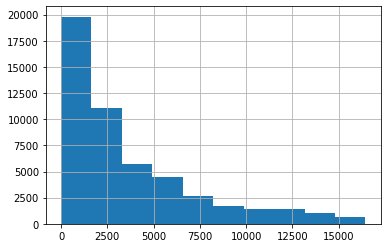

In [16]:
# распределение не нормально и разбеги слишком большие
df['ranking'].hist()

In [17]:
# нормируем ranking MinMaxScaller-ом, чтобы привести все значения в диапазон от 0 до 1
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df[['ranking']] = scaler.fit_transform(df[['ranking']])

In [18]:
'''
   Введем несколько дополнительных признаком: средний ranking на город, средний ranking на ресторанную сеть и тд. 
'''

def makeRankingDataFrame(sourceDf):    
    ranking = pd.DataFrame(sourceDf[['id', 'chain_id', 'ranking', 'city']])    
    
    mean_ranking_on_city = ranking.groupby(['city'])['ranking'].mean()
    mean_ranking_on_chain = ranking.groupby(['chain_id'])['ranking'].mean()
    max_ranking_on_city = ranking.groupby(['city'])['ranking'].max()    
        
    ranking['mean_ranking_on_city'] = ranking['city'].apply(lambda x: mean_ranking_on_city[x])         
    ranking['mean_ranking_on_city'] = ranking['ranking'] / ranking['mean_ranking_on_city']            
    
    ranking['max_ranking_on_city'] = ranking['city'].apply(lambda c: max_ranking_on_city[c])                
    ranking['max_ranking_on_city'] = ranking['ranking'] / ranking['max_ranking_on_city']            
    
    ranking['mean_ranking_on_chain'] = ranking['chain_id'].apply(lambda x: mean_ranking_on_chain[x])                        
    ranking['ranking_on_chain'] = ranking['ranking'] / ranking['mean_ranking_on_chain'];
    
    ranking = ranking.drop(['city', 'chain_id'], axis = 1)            
    return ranking

In [19]:
rankingDataFrame = makeRankingDataFrame(df)
display(rankingDataFrame.head())
display(rankingDataFrame.info())

,id,ranking,mean_ranking_on_city,max_ranking_on_city,mean_ranking_on_chain,ranking_on_chain
0,0,0.788299,1.868381,0.926850,0.049269,16.000000
1,1,0.006386,0.186424,0.092105,0.000693,9.210526
2,2,0.049200,0.915024,0.458357,0.003394,14.498208
3,3,0.101441,0.204194,0.101441,0.011433,8.872340
4,4,0.002189,0.078019,0.040541,0.000382,5.727273


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     50000 non-null  int64  
 1   ranking                50000 non-null  float64
 2   mean_ranking_on_city   50000 non-null  float64
 3   max_ranking_on_city    50000 non-null  float64
 4   mean_ranking_on_chain  50000 non-null  float64
 5   ranking_on_chain       50000 non-null  float64
dtypes: float64(5), int64(1)
memory usage: 2.3 MB


None

# Поле price_range

In [20]:
display(df['price_range'].value_counts())
display(df['price_range'].describe())

$$ - $$$    23041
$            7816
$$$$         1782
Name: price_range, dtype: int64

count        32639
unique           3
top       $$ - $$$
freq         23041
Name: price_range, dtype: object

In [21]:
'''
    В поле price_range содержатся номинативные признаки, которые можно расположить 
    в порядке возрастания. Пропуски логично будет заменить на среднее значение для текущего города.
'''

def makePriceRangeDataFrame(sourceDf):    
    price = pd.DataFrame(sourceDf[['id', 'price_range', 'city']])
    price['price_isna'] = pd.isna(price['price_range']).astype('uint8')
    
    price_dict = {'$': 10, '$$ - $$$': 1000, '$$$$': 10000}
    price = price.replace({'price_range': price_dict})        
    
    mean_price_range = price.groupby(['city'])['price_range'].mean()    
    def setPriceRange(city, currPriceRange):        
        if np.isnan(currPriceRange):            
            return mean_price_range[city]        
        return currPriceRange    
    price['price_range'] = price.apply(lambda row: setPriceRange(row['city'], row['price_range']), axis=1)                    
    
    price = price.drop(['city'], axis=1)
    return price

In [22]:
priceRangeDataFrame = makePriceRangeDataFrame(df)
display(priceRangeDataFrame.head())
display(priceRangeDataFrame.info())

,id,price_range,price_isna
0,0,1000.0,0
1,1,1000.0,0
2,2,1000.0,0
3,3,10000.0,0
4,4,10000.0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           50000 non-null  int64  
 1   price_range  50000 non-null  float64
 2   price_isna   50000 non-null  uint8  
dtypes: float64(1), int64(1), uint8(1)
memory usage: 830.2 KB


None

# Признак "reviews_count"

In [23]:
display(df['reviews_count'].describe())

count    46800.000000
mean       124.471197
std        294.114345
min          2.000000
25%          9.000000
50%         33.000000
75%        115.000000
max       9660.000000
Name: reviews_count, dtype: float64

In [24]:
'''
    Признак reviews_count распределен не нормально. Также содержит пустые значения.
    Для нормирования будем использовать извлечение квадратного корня, потому что это дало наилучший результат.
    Также для приближения можно использовать население и количество ресторанов в городе.
'''

def makeReviewsDataFrame(sourceDf):    
    reviews = pd.DataFrame(sourceDf[['id', 'reviews_count', 'city']])
    
    #reviews['reviews_count'] = reviews['reviews_count'].fillna(int(reviews['reviews_count'].mean()))             
    reviews['reviews_count'] = reviews['reviews_count'].fillna(0) # дало лучший результат при извлечении квадратного корня                       
    
    count_reviews_on_city = reviews.groupby(['city'])['reviews_count'].sum()    
    
    #reviews['reviews_count'] = np.log(reviews['reviews_count'])    
    reviews['reviews_count'] = reviews['reviews_count']**0.5
    reviews['reviews_count_on_city'] = reviews['city'].apply(lambda c: np.log(count_reviews_on_city[c]))            
    
    # вычислим среднее кол-во отзывов на человека (reviews_on_people_in_city) в одном городе
    reviews['reviews_on_people_in_city'] = reviews.apply(lambda row: row['reviews_count_on_city'] / population[row['city']], axis=1)
    # вычислим посещаемость ресторана
    reviews['attendance'] = reviews['reviews_count'] / reviews['reviews_on_people_in_city']    
    
    reviews = reviews.drop(['city', 'reviews_on_people_in_city'], axis=1)
    return reviews

In [25]:
reviewsDataFrame = makeReviewsDataFrame(df)
display(reviewsDataFrame.head())
display(reviewsDataFrame.info())

,id,reviews_count,reviews_count_on_city,attendance
0,0,2.000000,13.431064,3.261584e+05
1,1,9.848858,10.292518,6.155437e+05
2,2,5.291503,12.055848,2.142348e+05
3,3,14.212670,13.746985,9.209846e+06
4,4,12.727922,9.721486,5.667302e+05


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     50000 non-null  int64  
 1   reviews_count          50000 non-null  float64
 2   reviews_count_on_city  50000 non-null  float64
 3   attendance             50000 non-null  float64
dtypes: float64(3), int64(1)
memory usage: 1.5 MB


None

# Анализируем тональность комментариев

In [26]:
df['reviews'].iloc[30]

"[['Atmosphere and drinks nice', 'Spectacular Views'], ['08/05/2017', '09/30/2017']]"

In [27]:
positive_words = ['good', 'fine', 'delici', 'friendly', 'love', 'amazing', 'best', 'great' 'supper', 'exquis', 'tasty', 'savory', 'yummy', 'palatable', 'nice', 'nutty', 'fast', 'quick', 'well', 'ок', ')', 'purely', 'clean']
negative_words = ['unpa', 'bad', 'disap', 'nottasty', 'slow', 'dece', 'fraud', 'trick', 'hype', 'hoax', 'lie', 'false', 'untruth', 'menda', '(']

In [28]:
def words_count(words, comments):
    count = 0
    comments = comments.replace(' ', '').lower()
    for w in words:
        count += comments.count(w)
    return count

In [29]:
def makeTonalityDataFrame(sourceDf):    
    tonality = pd.DataFrame(sourceDf[['id', 'reviews']])      
    tonality['reviews'] = tonality['reviews'].replace('[[], []]', 'empty')
    tonality['reviews'] = tonality['reviews'].fillna('empty')    
    
    tonality['positive_words'] = tonality['reviews'].apply(lambda r: words_count(positive_words, r))
    tonality['negative_words'] = tonality['reviews'].apply(lambda r: words_count(negative_words, r))
    
    tonality = tonality.drop('reviews', axis=1)
    return tonality

In [30]:
tonalityDataFrame = makeTonalityDataFrame(df)
display(tonalityDataFrame.head())
display(tonalityDataFrame.info())

,id,positive_words,negative_words
0,0,0,0
1,1,2,0
2,2,0,0
3,3,2,0
4,4,2,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   id              50000 non-null  int64
 1   positive_words  50000 non-null  int64
 2   negative_words  50000 non-null  int64
dtypes: int64(3)
memory usage: 1.1 MB


None

# Даты комментариев

In [31]:
'''
    Даты двух комментариев распарсим на более раннюю и более позднюю. Попробуем вытащить дополнительные признаки
    из этих данных.
    Код честно украден из другого ноутбука.
'''

import ast
from datetime import datetime, timedelta 

df['reviews'] = df['reviews'].fillna('[[], []]')

def fill_last_review(row):        
    str_review = ast.literal_eval(str(row['reviews']).replace('nan','0'))
    if str_review == [[], []]:
        return 'NaN'
    elif len(str_review[1]) == 1:
        return(datetime.strptime(str_review[1][0],'%m/%d/%Y'))
    else:
        first_review_time = datetime.strptime(str_review[1][0],'%m/%d/%Y')
        second_review_time = datetime.strptime(str_review[1][1],'%m/%d/%Y')
        if first_review_time < second_review_time:
            return second_review_time
        else:
            return first_review_time
        
last_review = df.apply(lambda row:fill_last_review(row), axis=1)

def fill_old_review(row):    
    str_review = ast.literal_eval(str(row['reviews'].replace('nan','0')))
    if str_review == [[], []]:
        return 'NaN'
    elif len(str_review[1]) == 1:
        return(datetime.strptime(str_review[1][0],'%m/%d/%Y'))
    else:
        first_review_time = datetime.strptime(str_review[1][0],'%m/%d/%Y')
        second_review_time = datetime.strptime(str_review[1][1],'%m/%d/%Y')
        #print(row['Restaurant_id'])
        if first_review_time < second_review_time:
            return first_review_time
        else:
            return second_review_time
        

old_review = df.apply(lambda row:fill_old_review(row), axis=1)

datesDataframe = pd.DataFrame(df['id'])
datesDataframe['difference'] = (last_review - old_review).dt.days
datesDataframe['passed_time'] = (datetime.today()- last_review).dt.days

datesDataframe['difference_isNAN'] = pd.isna(datesDataframe['difference']).astype('uint8')
datesDataframe['passed_time_isNAN'] = pd.isna(datesDataframe['passed_time']).astype('uint8')

datesDataframe['difference'] = datesDataframe['difference'].fillna(0)
datesDataframe['passed_time'] = datesDataframe['passed_time'].fillna(0)

In [32]:
datesDataframe['passed_time'].describe()

count    50000.000000
mean       975.981800
std        543.198635
min          0.000000
25%        929.000000
50%        995.000000
75%       1159.000000
max       5934.000000
Name: passed_time, dtype: float64

In [33]:
display(datesDataframe.head())
display(datesDataframe.info())

,id,difference,passed_time,difference_isNAN,passed_time_isNAN
0,0,0.0,0.0,1,1
1,1,37.0,958.0,0,0
2,2,22.0,935.0,0,0
3,3,14.0,957.0,0,0
4,4,15.0,893.0,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 50000 non-null  int64  
 1   difference         50000 non-null  float64
 2   passed_time        50000 non-null  float64
 3   difference_isNAN   50000 non-null  uint8  
 4   passed_time_isNAN  50000 non-null  uint8  
dtypes: float64(2), int64(1), uint8(2)
memory usage: 1.2 MB


None

## Создаём, обучаем и тестируем модель

In [34]:
'''
    Используем стандартный код, который был в baseline. Уменьшим величину тестовой выборки.
'''

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

def train_model(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=RANDOM_SEED)   
    # Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
    model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)
    # Обучаем модель на тестовом наборе данных
    model.fit(X_train, y_train)
    # Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
    # Предсказанные значения записываем в переменную y_pred
    y_pred = model.predict(X_test)
    print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
    
    # в RandomForestRegressor есть возможность вывести самые важные признаки для модели
    plt.rcParams['figure.figsize'] = (10,10)
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    feat_importances.nlargest(15).plot(kind='barh')
    return model

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   41.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


MAE: 0.1941625


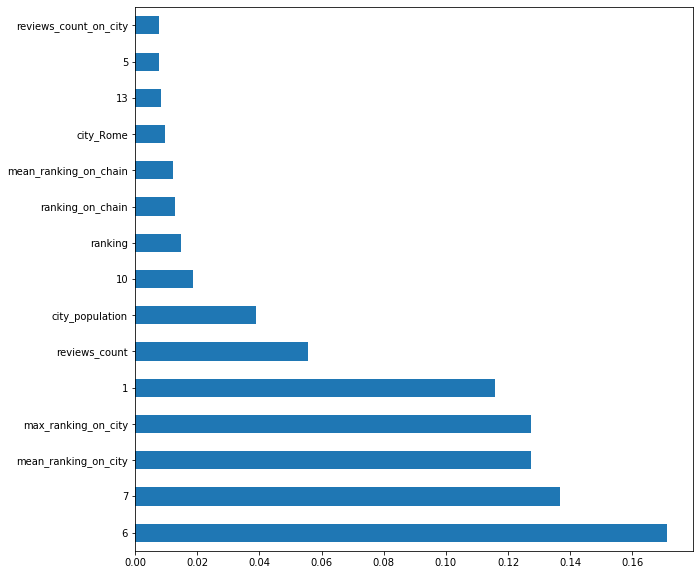

In [35]:
'''
    Соберем все признаки вместе и обучим модель. Включая/выключая некоторые датафреймы будем экспериментировать.
    Также добавим некоторые полиномиальные признаки. Действуем методом ручного подбора.
'''

from sklearn.preprocessing import PolynomialFeatures

data = pd.DataFrame(df[['id', 'chain_id', 'sample', 'rating']])
data = data.merge(restChainDataFrame, on='id', how='left')
data = data.merge(stylesDataFrame, on='id', how='left') 
data = data.merge(citiesDataFrame, on='id', how='left')
data = data.merge(countryDataFrame, on='id', how='left')
data = data.merge(capitalDataframe, on='id', how='left')
data = data.merge(rankingDataFrame, on='id', how='left')
data = data.merge(priceRangeDataFrame, on='id', how='left')
data = data.merge(reviewsDataFrame, on='id', how='left')
data = data.merge(tonalityDataFrame, on='id', how='left')
data = data.merge(datesDataframe, on='id', how='left')

#display(data.info())

pf = PolynomialFeatures(2)
poly_columns = ['max_ranking_on_city', 'attendance', 'difference', 'passed_time', 'city_Rome']
poly_features = pf.fit_transform(data[poly_columns])
data = pd.concat([pd.DataFrame(poly_features), data], axis =1)

# Выделим тестовую часть
columns_to_drop = ['sample', 'chain_id', 'id']
train_data = data.query('sample == 1.0').drop(columns_to_drop, axis=1)
test_data = data.query('sample == 0.0').drop(columns_to_drop, axis=1)

y = train_data.rating.values
X = train_data.drop(['rating'], axis=1)

model = train_model(X, y)

# Готовим Submission

In [36]:
test_data = test_data.drop(['rating'], axis=1)
predict_submission = model.predict(test_data)

sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


,Restaurant_id,Rating
0,id_0,3.290
1,id_1,4.425
2,id_2,4.430
3,id_3,4.340
4,id_4,4.490
5,id_5,4.320
6,id_6,1.830
7,id_7,3.315
8,id_8,4.210
9,id_9,4.545
